# Variational Monte Carlo simulation of Rydberg atoms

<br />

In this notebook, we show an application of recurrent neural networks (RNN) to discover the ground state of a many-body Hamiltonian. The RNN is used to parametrize the wavefunction of the Rydberg atoms, and its parameters are trained by minimizing the total energy using variational Monte Carlo. The RNN wavefunction and the training routines are implemented in the file `vmc.py`.

### Importing Tensorflow, Numpy, and Matplotlib 

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### RNN wavefunction

In [14]:
class VariationalMonteCarlo(tf.keras.Model):

    # Constructor
    def __init__(self, Lx, Ly, 
                 V, Omega, delta,
                 num_hidden, learning_rate,
                 epochs, seed=1234):
        
        super(VariationalMonteCarlo, self).__init__()

        """ PARAMETERS """
        self.Lx       = Lx              # Size along x
        self.Ly       = Ly              # Size along y
        self.V        = V               # Van der Waals potential
        self.Omega    = Omega           # Rabi frequency
        self.delta    = delta           # Detuning

        self.N        = Lx * Ly         # Number of spins
        self.nh       = num_hidden      # Number of hidden units in the RNN
        self.seed     = seed            # Seed of random number generator
        self.epochs   = epochs          # Training epochs 
        self.K        = 2               # Dimension of the local Hilbert space

        # Set the seed of the rng
        tf.random.set_seed(self.seed)

        # Optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate, epsilon=1e-8)

        # Build the model RNN
        # RNN layer: N -> nh
        self.rnn = tf.keras.layers.GRU(self.nh, kernel_initializer='glorot_uniform',
                                       kernel_regularizer = tf.keras.regularizers.l2(0.001),
                                       return_sequences = True,
                                       return_state = True,
                                       stateful = False)

        # Dense layer: nh - > K
        self.dense = tf.keras.layers.Dense(self.K, activation = tf.nn.softmax,
                                           kernel_regularizer = tf.keras.regularizers.l2(0.001))

        # Generate the list of bonds for NN,NNN,NNNN on a 
        # square lattice with open boundaries
        self.buildlattice()
    
    @tf.function
    def sample(self,nsamples):
        # Zero initialization for visible and hidden state 
        inputs = 0.0*tf.one_hot(tf.zeros(shape=[nsamples,1],dtype=tf.int32),depth=self.K)
        hidden_state = tf.zeros(shape=[nsamples,self.nh])

        logP = tf.zeros(shape=[nsamples,],dtype=tf.float32)

        for j in range(self.N):
            # Run a single RNN cell
            rnn_output,hidden_state = self.rnn(inputs,initial_state=hidden_state)
            # Compute log probabilities
            probs = self.dense(rnn_output)
            log_probs = tf.reshape(tf.math.log(1e-10+probs),[nsamples,self.K])
            # Sample
            sample = tf.random.categorical(log_probs,num_samples=1)
            if (j == 0):
                samples = tf.identity(sample)
            else:
                samples = tf.concat([samples,sample],axis=1)
            # Feed result to the next cell
            inputs = tf.one_hot(sample,depth=self.K)
            add = tf.reduce_sum(log_probs*tf.reshape(inputs,(nsamples,self.K)),axis=1)

            logP = logP+tf.reduce_sum(log_probs*tf.reshape(inputs,(nsamples,self.K)),axis=1)

        return samples,logP

    @tf.function
    def logpsi(self,samples):
        # Shift data
        num_samples = tf.shape(samples)[0]
        data   = tf.one_hot(samples[:,0:self.N-1],depth=self.K)

        x0 = 0.0*tf.one_hot(tf.zeros(shape=[num_samples,1],dtype=tf.int32),depth=self.K)
        inputs = tf.concat([x0,data],axis=1)

        hidden_state = tf.zeros(shape=[num_samples,self.nh])
        rnn_output,_ = self.rnn(inputs,initial_state = hidden_state)
        probs        = self.dense(rnn_output)

        log_probs   = tf.reduce_sum(tf.multiply(tf.math.log(1e-10+probs),tf.one_hot(samples,depth=self.K)),axis=2)

        return 0.5*tf.reduce_sum(log_probs,axis=1)

    #@tf.function
    def localenergy(self,samples,logpsi):
        eloc = tf.zeros(shape=[tf.shape(samples)[0]],dtype=tf.float32)

        # Chemical potential
        for j in range(self.N):
            eloc += - self.delta * tf.cast(samples[:,j],tf.float32)
     
        for n in range(len(self.nns)):
            eloc += (self.V/self.nns[n][0]) * tf.cast(samples[:,self.nns[n][1]]*samples[:,self.nns[n][2]],tf.float32)
        

        # Off-diagonal part
        for j in range(self.N):
            flip_samples = np.copy(samples)
            flip_samples[:,j] = 1 - flip_samples[:,j]
            flip_logpsi = self.logpsi(flip_samples)
            eloc += -0.5*self.Omega * tf.math.exp(flip_logpsi-logpsi)

        return eloc

    """ Generate the square lattice structures """
    def coord_to_site(self,x,y):
        return self.Ly*x+y
    
    def buildlattice(self):
        self.nns = []
        trunc_n = self.Lx
        trunc_n_ = self.Ly
        
        for n in range(1,self.Lx):
            for n_ in range(n+1):
                
                if n > trunc_n and n_ > trunc_n_ :
                    continue
        
                else:
                    for x in range(self.Lx-n_):
                        for y in range(self.Ly-n):
                            coeff = np.sqrt(n**2+n_**2)**6
                            if n_ == 0 :
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x,y+n)])
                            elif n == n_: 
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n,y+n)])
                                self.nns.append([coeff,self.coord_to_site(x+n,y),self.coord_to_site(x,y+n)])
                            else:
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n_,y+n)])
                                self.nns.append([coeff,self.coord_to_site(x+n_,y),self.coord_to_site(x,y+n)])
                            
                    for y in range(self.Ly-n_):
                        for x in range(self.Lx-n):
                            coeff = np.sqrt(n**2+n_**2)**6
                            if n_ == 0 :
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n,y)])
                            elif n == n_: 
                                continue #already counted above
                            else:
                                self.nns.append([coeff,self.coord_to_site(x,y),self.coord_to_site(x+n,y+n_)])
                                self.nns.append([coeff,self.coord_to_site(x,y+n_),self.coord_to_site(x+n,y)])


### Testing Buildlattice loops

In [15]:
Lx = 4
Ly = 4
nns = []

def coord_to_site(x,y):
        return Ly*x+y

for n in range(1,Lx):
    for n_ in range(n+1):
        trunc_n= Lx
        trunc_n_ = Lx
        
        if n > trunc_n and n_ > trunc_n_:
            continue
        
        else:
            for x in range(Lx-n_):
                for y in range(Ly-n):
                    coeff = np.sqrt(n**2+n_**2)**6
                    if n_ == 0 :
                        nns.append([coeff,coord_to_site(x,y),coord_to_site(x,y+n)])
                    elif n == n_:
                        nns.append([coeff,coord_to_site(x,y),coord_to_site(x+n,y+n)])
                        nns.append([coeff,coord_to_site(x+n,y),coord_to_site(x,y+n)])
                    else:
                        nns.append([coeff,coord_to_site(x,y),coord_to_site(x+n_,y+n)])
                        nns.append([coeff,coord_to_site(x+n_,y),coord_to_site(x,y+n)])
                    
            for y in range(Ly-n_):
                for x in range(Lx-n):
                    coeff = np.sqrt(n**2+n_**2)**6
                    if n_ == 0 :
                        nns.append([coeff,coord_to_site(x,y),coord_to_site(x+n,y)])
                    elif n == n_:
                        continue
                    else:
                        nns.append([coeff,coord_to_site(x,y),coord_to_site(x+n,y+n_)])
                        nns.append([coeff,coord_to_site(x,y+n_),coord_to_site(x+n,y)])

print(nns, len(nns))

[[1.0, 0, 1], [1.0, 1, 2], [1.0, 2, 3], [1.0, 4, 5], [1.0, 5, 6], [1.0, 6, 7], [1.0, 8, 9], [1.0, 9, 10], [1.0, 10, 11], [1.0, 12, 13], [1.0, 13, 14], [1.0, 14, 15], [1.0, 0, 4], [1.0, 4, 8], [1.0, 8, 12], [1.0, 1, 5], [1.0, 5, 9], [1.0, 9, 13], [1.0, 2, 6], [1.0, 6, 10], [1.0, 10, 14], [1.0, 3, 7], [1.0, 7, 11], [1.0, 11, 15], [8.000000000000004, 0, 5], [8.000000000000004, 4, 1], [8.000000000000004, 1, 6], [8.000000000000004, 5, 2], [8.000000000000004, 2, 7], [8.000000000000004, 6, 3], [8.000000000000004, 4, 9], [8.000000000000004, 8, 5], [8.000000000000004, 5, 10], [8.000000000000004, 9, 6], [8.000000000000004, 6, 11], [8.000000000000004, 10, 7], [8.000000000000004, 8, 13], [8.000000000000004, 12, 9], [8.000000000000004, 9, 14], [8.000000000000004, 13, 10], [8.000000000000004, 10, 15], [8.000000000000004, 14, 11], [64.0, 0, 2], [64.0, 1, 3], [64.0, 4, 6], [64.0, 5, 7], [64.0, 8, 10], [64.0, 9, 11], [64.0, 12, 14], [64.0, 13, 15], [64.0, 0, 8], [64.0, 4, 12], [64.0, 1, 9], [64.0, 5, 1

### Define parameters

In [16]:
# Hamiltonian parameters
Lx = 4      # Linear size in x direction
Ly = 4      # Linear size in y direction
N = Lx*Ly   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 

# RNN-VMC parameters
lr = 0.001     # learning rate of Adam optimizer
nh = 32        # Number of hidden units in the GRU cell
ns = 500       # Number of samples used to approximate the energy at each step
epochs = 1000  # Training iterations
seed = 1234    # Seed of RNG

# Exact energy from exact diagonalization
exact_energy = -0.45776822

In [17]:
print("Running VMC for delta =",delta)
vmc = VariationalMonteCarlo(Lx,Ly,V,Omega,delta,nh,lr,epochs,seed)
energy = []
variance = []
for n in range(1,epochs+1):
    samples, _ = vmc.sample(ns)
    
    # Evaluate the loss function in AD mode
    with tf.GradientTape() as tape:
        logpsi = vmc.logpsi(samples)
        eloc = vmc.localenergy(samples, logpsi)
        Eo = tf.stop_gradient(tf.reduce_mean(eloc))

        loss = tf.reduce_mean(2.0*tf.multiply(logpsi, tf.stop_gradient(eloc)) - 2.0*Eo*logpsi)
    
    # Compute the gradients
    gradients = tape.gradient(loss, vmc.trainable_variables)
    
    # Update the parameters
    vmc.optimizer.apply_gradients(zip(gradients, vmc.trainable_variables))    
    
    energies = eloc.numpy()
    avg_E = np.mean(energies)/float(N)
    var_E = np.var(energies)/float(N)
    energy.append(avg_E)

Running VMC for delta = 1.0


final energy =  -0.42561089992523193
exact energy =  -0.45776822
error =  -0.03215732007476807


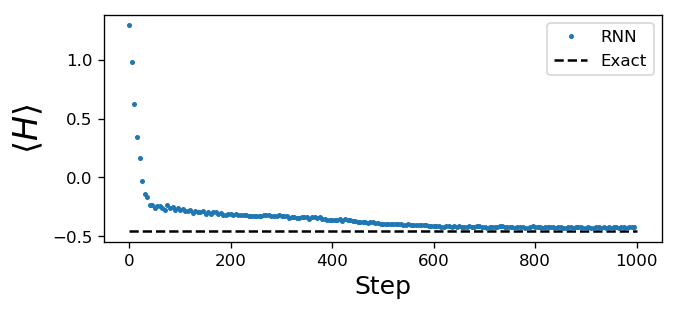

In [18]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(energy,marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN")
plt.hlines(exact_energy,0,1000,linestyle="--",label="Exact")

plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")
print('final energy = ',energy[-1])
print('exact energy = ',exact_energy)
print('error = ',exact_energy-energy[-1])

plt.show()